<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 250
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
# !wget --no-check-certificate \
#    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
#    -O /tmp/sarcasm.json


In [4]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
training_sentences[0]

"former versace store clerk sues over secret 'black code' for minority shoppers"

### Load NumPy arrays with tf.data.Dataset

Assuming you have an array of examples and a corresponding array of labels, pass the two arrays as a tuple into tf.data.Dataset.from_tensor_slices to create a tf.data.Dataset.

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_sentences, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((testing_sentences, testing_labels))

In [8]:
text_batch, label_batch = next(iter(train_dataset.batch(3)))
for i in range(3):
    print (text_batch.numpy()[i])
    print (label_batch.numpy()[i])

b"former versace store clerk sues over secret 'black code' for minority shoppers"
0
b"the 'roseanne' revival catches up to our thorny political mood, for better and worse"
0
b"mom starting to fear son's web series closest thing she will have to grandchild"
1


In [12]:
int_vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length)

In [13]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = train_dataset.map(lambda text, labels: text)
int_vectorize_layer.adapt(train_text)

In [15]:
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [47]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(train_dataset.batch(2)))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", first_label)
print("'int' vectorized question:",
      int_vectorize_text(first_question, first_label)[0])

Question tf.Tensor(b"former versace store clerk sues over secret 'black code' for minority shoppers", shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int32)
'int' vectorized question: tf.Tensor(
[[ 319    1  943 4079 2366   47  366   94 2026    6 2653 9469    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

In [14]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  boehner
313 --->  girl
Vocabulary size: 10000


In [16]:
int_train_ds = train_dataset.map(int_vectorize_text)
int_test_ds = test_dataset.map(int_vectorize_text)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
int_train_ds = configure_dataset(int_train_ds)
int_test_ds = configure_dataset(int_test_ds)

In [53]:
def create_model(vocab_size, num_labels):
  model = tf.keras.Sequential([
      # layers.Embedding(vocab_size, 64, mask_zero=True),
      # layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      # layers.GlobalMaxPooling1D(),
      # layers.Dense(num_labels)
      layers.GlobalAveragePooling1D(),
      layers.Dense(64, activation='relu'),
      layers.Dense(1, activation='sigmoid')
  ])
  return model

In [54]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4)
int_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
history = int_model.fit(int_train_ds.shuffle(10000).batch(256), validation_data=int_test_ds.batch(256), epochs=5)

Epoch 1/5
79/79 [==============================] - 1s 4ms/step - loss: 45.8765 - accuracy: 0.5114 - val_loss: 20.9260 - val_accuracy: 0.5178
Epoch 2/5
79/79 [==============================] - 0s 3ms/step - loss: 17.6091 - accuracy: 0.5246 - val_loss: 14.4840 - val_accuracy: 0.5087
Epoch 3/5
79/79 [==============================] - 0s 3ms/step - loss: 13.2278 - accuracy: 0.5262 - val_loss: 11.5604 - val_accuracy: 0.5245
Epoch 4/5
79/79 [==============================] - 0s 3ms/step - loss: 11.0517 - accuracy: 0.5319 - val_loss: 10.0389 - val_accuracy: 0.5215
Epoch 5/5
79/79 [==============================] - 0s 3ms/step - loss: 9.6285 - accuracy: 0.5365 - val_loss: 10.3507 - val_accuracy: 0.4907


In [28]:
print("ConvNet model on int vectorized data:")
print(int_model.summary())

ConvNet model on int vectorized data:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling1d_4   (None, 250)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 64)                16064     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,129
Trainable params: 16,129
Non-trainable params: 0
_________________________________________________________________
None


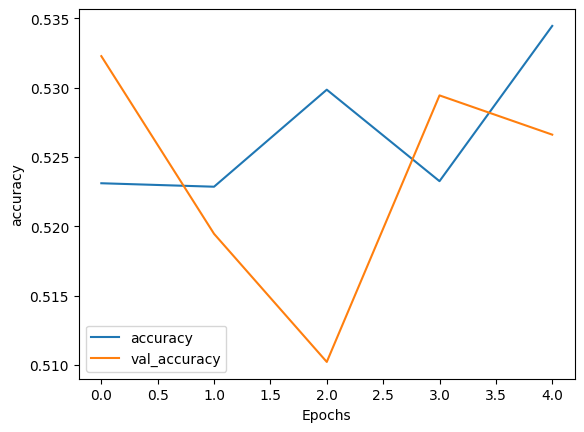

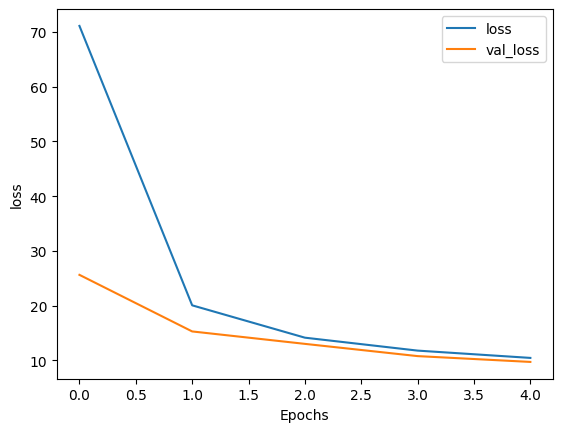

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")